## Image classification following Keras example

Ideas come from [here](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

## Path and names

In [1]:
train_PATH = '../classification_set/train/'
valid_PATH = '../classification_set/validation/'
name = 'lung_no_aug'

## Libraries

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

import matplotlib.pyplot as plt

import pickle

import numpy as np

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve, f1_score, auc

Using TensorFlow backend.


## Convolution and pooling layers

In [3]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

## Fully connected layer

In [4]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Compile the model

In [5]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Load dataset

In [6]:
batch_size = 16

In [7]:
# training with augmentation 
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)
train_datagen = ImageDataGenerator(rescale=1./255)

# test only rescale
validation_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
        train_PATH,  
        target_size=(150, 150),  
        batch_size=batch_size,
        class_mode='binary')  

# validation set is not shuffled
validation_generator = validation_datagen.flow_from_directory(
        valid_PATH,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

Found 589 images belonging to 2 classes.
Found 147 images belonging to 2 classes.


In [9]:
train_size = len(train_generator.filenames)
validation_size = len(validation_generator.filenames)

## Fitting the model

In [10]:
model.fit_generator(
        train_generator,
        steps_per_epoch= train_size // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps= validation_size // batch_size)

Epoch 1/50
36/36 [==============================] - 77s 2s/step - loss: 0.5672 - accuracy: 0.7696 - val_loss: 0.1439 - val_accuracy: 0.7917
Epoch 2/50
36/36 [==============================] - 98s 3s/step - loss: 0.5304 - accuracy: 0.7958 - val_loss: 0.4220 - val_accuracy: 0.7710
Epoch 3/50
36/36 [==============================] - 109s 3s/step - loss: 0.5493 - accuracy: 0.7923 - val_loss: 0.1931 - val_accuracy: 0.7710
Epoch 4/50
36/36 [==============================] - 7294s 203s/step - loss: 0.5258 - accuracy: 0.8028 - val_loss: 0.0729 - val_accuracy: 0.7710
Epoch 5/50
36/36 [==============================] - 7284s 202s/step - loss: 0.5182 - accuracy: 0.7906 - val_loss: 0.2141 - val_accuracy: 0.7710
Epoch 6/50
36/36 [==============================] - 14508s 403s/step - loss: 0.5422 - accuracy: 0.7923 - val_loss: 0.2816 - val_accuracy: 0.7710
Epoch 7/50
36/36 [==============================] - 605s 17s/step - loss: 0.5109 - accuracy: 0.8010 - val_loss: 0.3236 - val_accuracy: 0.7710
Epoc

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)       

## Save the model

In [12]:
#model arch and weigths 
model.save(f'{name}_model.h5') 

#history dictionary
with open(f'{name}_history.dict', 'wb') as file_pi:
        pickle.dump(model.history.history, file_pi)

## Training evaluation

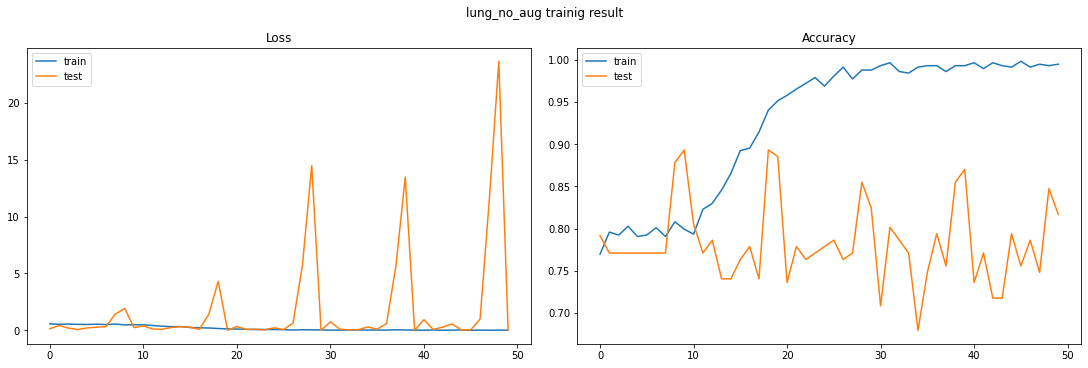

In [13]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,5), constrained_layout=True,)

_ = fig.suptitle(f'{name} trainig result')

_ = ax1.set_title('Loss')
_ = ax1.plot(model.history.history['loss'], label='train')
_ = ax1.plot(model.history.history['val_loss'], label='test')
_ = ax1.legend()

_ = ax2.set_title('Accuracy')
_ = ax2.plot(model.history.history['accuracy'], label='train')
_ = ax2.plot(model.history.history['val_accuracy'], label='test')
_ = ax2.legend()

plt.savefig(f'{name}_trainig_result.png')

## Predictions and metrics

In [14]:
def convert_to_binary(y):
    pred_class = []
    pred_prob = []
    
    for i in range(len(y)):
        pred_prob.append(y[i][0])
                   
        if y[i][0]>=0.5:
            pred_class.append(1)
        else:
            pred_class.append(0)
            
    return np.asarray(pred_class), np.asarray(pred_prob)

In [15]:
#real
y_real = validation_generator.classes

#predicted
test_pred_prob = model.predict(validation_generator)
y_pred_class, y_pred_prob = convert_to_binary(test_pred_prob)

In [16]:
y_real

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [17]:
y_pred_class

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [18]:
precision = precision_score(y_real, y_pred_class)
recall = recall_score(y_real, y_pred_class)

fpr_th, tpr_th, _ = roc_curve(y_real, y_pred_prob)
AUC_ROC = auc(fpr_th, tpr_th)

precision_th, recall_th, _ = precision_recall_curve(y_real, y_pred_prob)
PR_AUC = auc(recall_th, precision_th)

In [19]:
print ('Precision =',precision)
print ('Recall =',recall)
print ('Area under ROC curve =',AUC_ROC)
print ('Area under precision-Recall curve =',PR_AUC)

Precision = 0.8333333333333334
Recall = 0.8547008547008547
Area under ROC curve = 0.5756410256410257
Area under precision-Recall curve = 0.8567089197143221


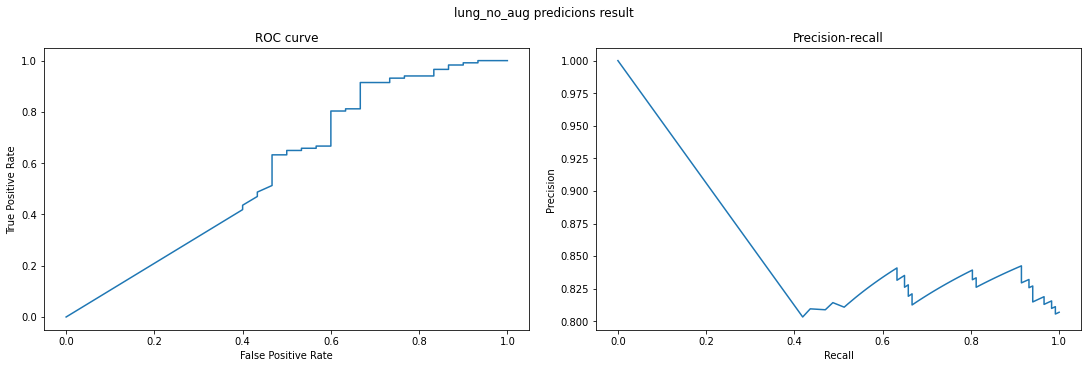

In [20]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,5), constrained_layout=True,)

_ = fig.suptitle(f'{name} predicions result')

_ = ax1.set_title('ROC curve')
_ = ax1.plot(fpr_th, tpr_th)
_ = ax1.set_xlabel('False Positive Rate')
_ = ax1.set_ylabel('True Positive Rate')


_ = ax2.set_title('Precision-recall')
_ = ax2.plot(recall_th, precision_th)
_ = ax2.set_xlabel('Recall')
_ = ax2.set_ylabel('Precision')


plt.savefig(f'{name}_predictions_result.png')